# Интегрирование.

Вычисление числа  π  методом Монте-Карло. 

In [287]:
import random
import math
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sps

plt.rcParams.update({"font.size" : 14, "font.family" : "serif"})

N = 1000000
count = 0
for i in range(N):
    x = random.uniform(-1, 1)
    y = random.uniform(-1, 1)
    if (x**2 + y**2 <= 1):
        count += 1
print(4*count/N)


3.142136


Анализ погрешности

In [7]:
N = 1000000
M = 256
pis = []
for i in range(M):
    x = np.random.uniform(-1, 1, N)
    y = np.random.uniform(-1, 1, N)
    pis.append(4*np.sum(x**2 + y**2 <= 1) / N)

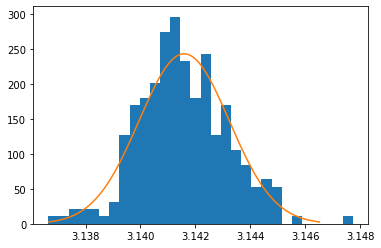

In [9]:
plt.hist(pis, bins=30, density=True)
sigma = np.sqrt(math.pi*(4-math.pi)/N)
xs = np.arange(math.pi - 3*sigma, math.pi + 3*sigma, 1e-6)
plt.plot(xs, 1/np.sqrt(2*math.pi*sigma**2)*np.exp(-(xs - math.pi)**2 / 2 / sigma**2))

## 1.  Закон всемирного тяготения. 

Используем метод для вычисления силы взаимного притяжения Луны и Земли. Для простоты предположим, что плотности Земли и Луны не зависят от координат и возьмем их средние значения. Для проведения численного эксперимента нам понадобятся следующие физические величины:

$$
\begin{aligned}
& G=6.67 \cdot 10^{-11} \frac{\mathrm{H} \cdot \mathrm{м}^2}{\text { кг }}-\text { гравитационная постоянная; } \\
& m_1=6 \cdot 10^{24} \mathrm{ кг }-\text { масса Земли; } \\
& m_2=7.35 \cdot 10^{22} \text { кг }-\text { масса Луны; } \\
& r=384467000 \mathrm{ м}-\text { pacстояние между Луной и Землей; } \\
& \rho_1=5520 \frac{\mathrm{ кг }}{\mathrm{м}^3}-\text { средняя плотность Земли; } \\
& \rho_2=3346 \frac{\mathrm{кг}}{\mathrm{м}^3}-\text { средняя плотность Луны; } \\
& R_1=6367000 \mathrm{м}-\text { радиус Земли; } \\
& R_2=1737000 \mathrm{м}-\text { радиус Луны. }
\end{aligned}
$$

Поскольку тела сферические со сферически симметричной функцией плотности (константой), то объекты можно рассматривать как точечные и вычислить их силу притяжения по формуле:

$$
F=G \frac{m_1 \cdot m_2}{r^2},
$$

где $m_1$ и $m_2$ массы точечных объектов. Это значение будем использовать для сравнения с результатами вычислений с помощью метода Монте-Карло. По формуле  находим значение силы

$$
F=1.98997 \cdot 10^{20} \mathrm{H} .
$$

Результаты вычислений этой силы с помощью метода Монте-Карло и аналитически сравнить между собой. Построить график зависимости ошибки от числа итераций в логарифмическом масштабе , сделать вывод об асимптотике ошибки.


Предположу, что автор задачи хотел, чтобы студенты 
сэмплировали координаты точек внутри шарика Земли и шарика Луны, для них
вычисляли силы притяжения, а затем из этого вычисляли бы силу притяжения между Землей и Луной

In [176]:
# Сэмплируем точки внутри шариков, считаем силы, усредняем и домножаем на объёмы тел. 
# Ось х считаем направленной вдоль линии, соединяющий центры шариков

ro1, ro2 = 5520, 3346
m1, m2 = 6e24, 7.35e22
R1, R2 = 6367000, 1737000
G = 6.67e-11
r = 384467000
vol1 = 4*np.pi/3 * R1**3
vol2 = 4*np.pi/3 * R2**3


def sampler_naive(size=1000):
    rad1 = np.random.uniform(low=0,high=R1, size=size)
    rad2 = np.random.uniform(low=0,high=R2, size=size)
    phi1 = np.random.uniform(low=0,high=2*np.pi, size=size)
    phi2 = np.random.uniform(low=0,high=2*np.pi, size=size)
    theta1 = np.random.uniform(low=0, high=np.pi, size=size)
    theta2 = np.random.uniform(low=0, high=np.pi, size=size)
    
    x1, y1, z1 = rad1*np.sin(theta1)*np.cos(phi1), rad1*np.sin(theta1)*np.sin(phi1), rad1*np.cos(theta1)
    x2, y2, z2 = rad2*np.sin(theta2)*np.cos(phi2)+r, rad1*np.sin(theta2)*np.sin(phi2), rad2*np.cos(theta2)
    
    cord1 = np.dstack((x1,y1,z1))[0]
    cord2 = np.dstack((x2,y2,z2))[0]
    
    return cord1, cord2

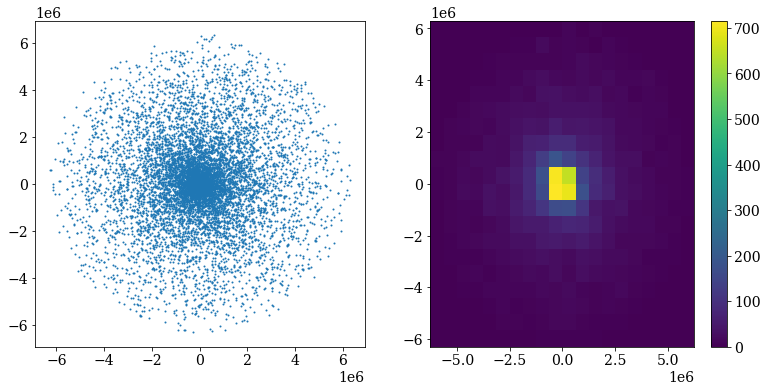

In [177]:
cord1, cord2 = sampler_naive(10000)
x, y, z = cord1.T

plt.figure(figsize=(13,6))
plt.subplot(121)
plt.scatter(x, y, s=1)

plt.subplot(122)
plt.hist2d(x,y, bins=20)
plt.colorbar()

Хорошо видно, что простой способ сэмплирования не подходит - все точки в основном вблизи центра. Можно сделать либо rejection sampling, либо преобразовать наше равномерное распределение(inverse cdf)

In [157]:
def sampler_rejection(size=1000):
    x1, y1, z1 = np.random.uniform(low=-R1, high=R1, size=size),np.random.uniform(low=-R1, high=R1, size=size),np.random.uniform(low=-R1, high=R1, size=size)
    x2, y2, z2 = np.random.uniform(low=-R2, high=R2, size=size),np.random.uniform(low=-R2, high=R2, size=size),np.random.uniform(low=-R2, high=R2, size=size)
    
    l1 = x1.shape[0]
    cord1 = np.dstack((x1,y1,z1))[0]
    cord1 = cord1[np.linalg.norm(cord1,ord=2,axis=1)<R1]
    cord2 = np.dstack((x2,y2,z2))[0]
    cord2 = cord2[np.linalg.norm(cord2,ord=2,axis=1)<R2]
    cord2 += np.array([r, 0, 0])
    
    cut = min(cord1.shape[0], cord2.shape[0])
    cord1, cord2 = cord1[:cut], cord2[:cut]
    acc_rate = cord1.shape[0]/l1
    
    return cord1, cord2, acc_rate

Acceptance rate 0.52


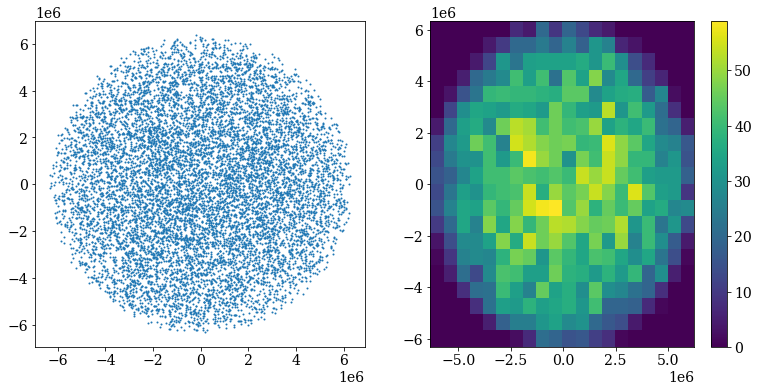

In [164]:
cord1, cord2, acc_rate = sampler_rejection(20000)
x, y, z = cord1.T
plt.figure(figsize=(13,6))
plt.subplot(121)
plt.scatter(x, y, s=1)

plt.subplot(122)
plt.hist2d(x,y, bins=20)
plt.colorbar()
print("Acceptance rate", acc_rate)

При таком подходе сэмплируется всё правильно, но примерно половина точек выкидывается. Здесь можно применить inverse cdf метод, получить acceptance rate 1, но он будет вычислительно дорогой, так как нужно будет извлекать корни и брать арккосинусы

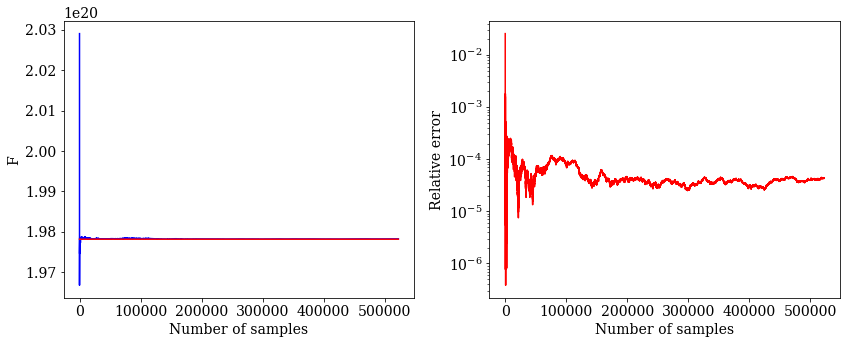

In [175]:
N = 1000000

cord1, cord2, acc_rate = sampler_rejection(N)

dist = np.linalg.norm(cord1 - cord2, ord=2, axis=1)
F = G*vol1*vol2*ro1*ro2/dist**2 

ans = np.cumsum(F)/np.arange(1, F.shape[0]+1)
real_ans = vol1*ro1 * vol2*ro2 * G / r**2


plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(np.arange(1, F.shape[0]+1), ans,
        color="blue",
        label="Monte Carlo")
plt.plot(np.arange(1, F.shape[0]+1), real_ans*np.ones(F.shape[0]), 
         color="red", 
         label='Real answer')

plt.xlabel("Number of samples")
plt.ylabel("F")

plt.subplot(122)
plt.semilogy(np.arange(1, F.shape[0]+1), abs((ans/real_ans-np.ones(F.shape[0]))), 
         color="red")

plt.xlabel("Number of samples")
plt.ylabel("Relative error")
    
plt.tight_layout()

## 2. Расчёт прохождения нейтронов сквозь пластинку.


Пусть на однородную пластинку бесконечной площади толщиной $\mathrm{h}$ нормально падает поток нейтронов с энергией $\mathrm{E}_0$. При столкновении с атомами вещества, из которого состоит пластинка, нейтроны могут: а) упруго рассеиваться; б) поглощаться. Пусть при упругом рассеянии: энергия не меняется; равновероятно любое направление рассеяния. Сечения поглощения и сечения рассеяния нейтронов считать известными. Требуется вычислить:
- вероятность прохождения нейтрона сквозь пластинку $Р+$,
- вероятность отражения нейтронов от пластинки $Р-$
- вероятность поглощения нейтрона в пластинке $Р_О$.

https://mipt.ru/upload/Лекция%208%20Монте%20Карло%20и%20перколяции.pdf

In [104]:
def sample_lambda(sigma_s, sigma_a, size=1000):
    gamma = np.random.uniform(low=0.001, high=1.0, size=size)
    return -1/(sigma_s+sigma_a)*np.log(gamma)

def sample_cossin(size=1000):
    rand_sign = np.random.choice([-1,1],size=size)
    cos = np.random.uniform(low=-1.0, high=1.0, size=size)
    sin = rand_sign*np.sqrt(1-cos**2)
    return cos, sin


def modelling(h, sigma_s, sigma_a, iters=10000, size=1000):
    trajectories = []
    count_absorbed = 0
    count_reflected = 0
    count_transmitted = 0 
    new_iters = iters
    ps, pa = sigma_s/(sigma_s+sigma_a), sigma_a/(sigma_s+sigma_a)
    
    for _ in range(iters):
        act = np.random.choice([0, 1], p=[pa, ps], size=size)
        
        try:
            act = np.argwhere(act==0)[0,0]
            new_size = act + 1
        except IndexError:
            new_size = size
        
        l = sample_lambda(sigma_a, sigma_s, new_size)
        cos, sin = sample_cossin(new_size)
        dx, dy = l*cos, l*sin 
        x, y = np.append([0, l[0]], np.cumsum(dx[1:])), np.append([0, 0],np.cumsum(dy[1:]))
        
        try:
            idx_neg = np.argwhere(x<0)[0,0]
        except IndexError:
            idx_neg = np.inf
        try:
            idx_pos = np.argwhere(x>h)[0,0]
        except IndexError:
            idx_pos = np.inf

            
        if idx_neg < idx_pos:
            count_reflected +=1 
            x, y = x[:idx_neg+1], y[:idx_neg+1]
        elif idx_pos < idx_neg:
            count_transmitted +=1 
            x, y = x[:idx_pos+1], y[:idx_pos+1]
        else:
            count_absorbed += 1
            
        cord = np.dstack((x, y))[0]
        trajectories.append(cord)
    
    return trajectories, [count_absorbed/new_iters, count_reflected/new_iters, count_transmitted/new_iters]


def visualise_modelling(trajectories, probs, h):
    plt.figure(figsize=(10, 5))
    
    for t in trajectories:
        x, y = t.T
        plt.plot(x, y)
        
    plt.axvspan(0, h, alpha=0.2, color='red')
    plt.axvline(0, color="red")
    plt.axvline(h, color="red")
  
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title("Trajectories of neutrons")
    
    pa, pr, pt = probs
    
    print("Probabilities")
    print("_____________________________")
    print("Absorbed prob    : {}".format(round(pa, 2)))
    print("Reflected prob   : {}".format(round(pr, 2)))
    print("Transmitted prob : {}".format(round(pt, 2)))
    print("_____________________________")
    


1.0
Probabilities
_____________________________
Absorbed prob    : 0.19
Reflected prob   : 0.62
Transmitted prob : 0.2
_____________________________


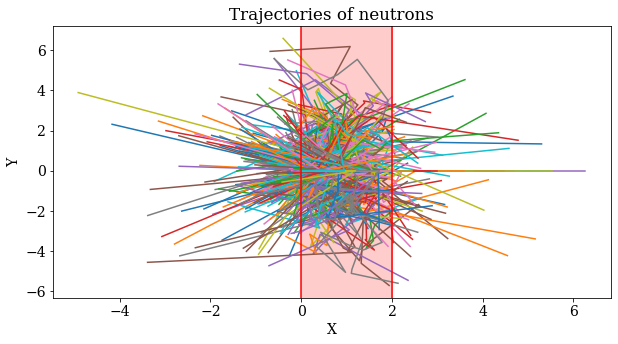

In [105]:
h, sigma_s, sigma_a = 2, 1, 0.1
size, iters = 1000, 1000

trajectories, probs = modelling(h, sigma_s, sigma_a, size=size, iters=iters)
print(len(trajectories)/size)


visualise_modelling(trajectories, probs, h)

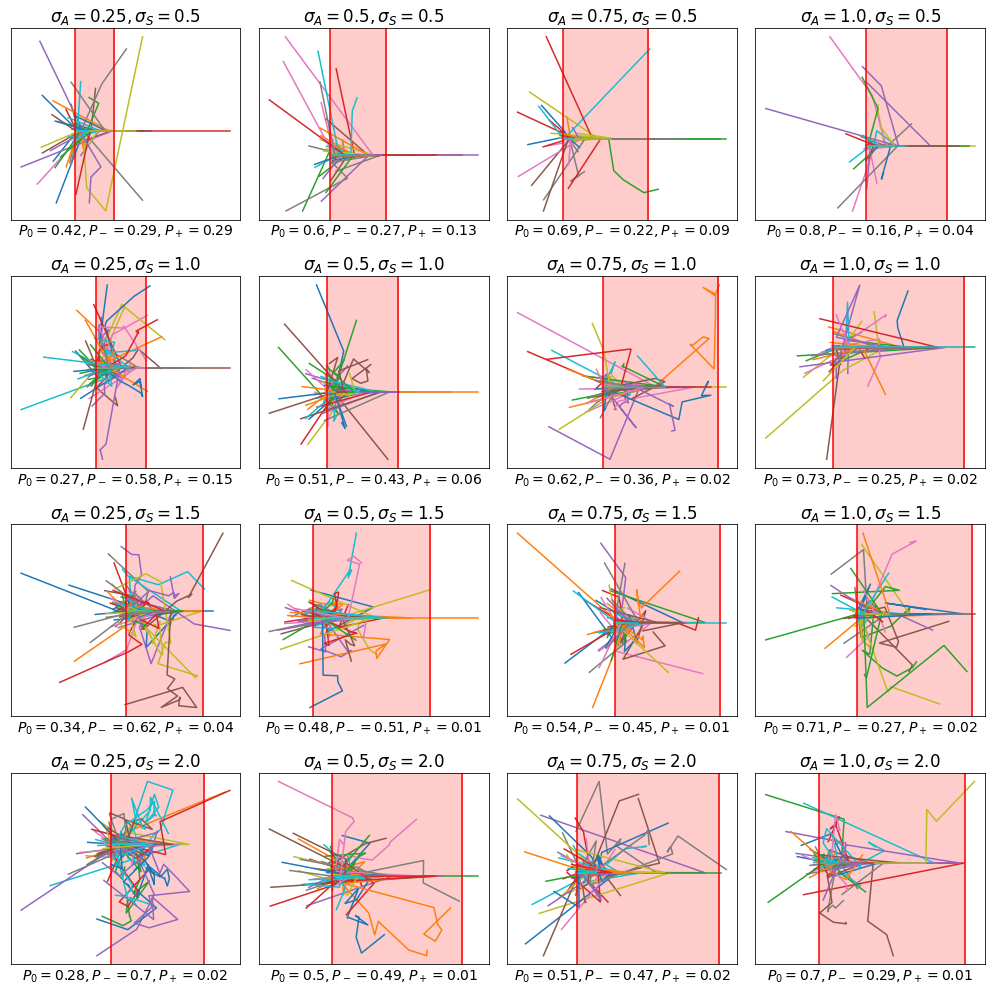

In [121]:
SIGMA_S, SIGMA_A = np.arange(0.5, 2.1, 0.5), np.arange(0.25, 1.1, 0.25)

len_S, len_A = SIGMA_S.shape[0], SIGMA_A.shape[0]


plt.figure(figsize=(14, 14))
i = 1
for S in SIGMA_S:
    for A in SIGMA_A:
        plt.subplot(len_S, len_A, i)
        i += 1
        trajectories, probs = modelling(h, S, A, size=1000, iters=100)

        for t in trajectories:
            x, y = t.T
            plt.plot(x, y)
            plt.xticks([])
            plt.yticks([])
        plt.title("$\\sigma_A = {}, \\sigma_S = {}$".format(A, S))
        plt.xlabel("$P_0 = {}, P_- = {}, P_+ = {}$".format(*probs))
            
        plt.axvspan(0, h, alpha=0.2, color='red')
        plt.axvline(0, color="red")
        plt.axvline(h, color="red")
        
plt.tight_layout()

## 3. Случайное блуждание.

Рассмотрим одномерное случайное блуждание, где на каждом шаге с вероятностью $1 / 2$ точка движется влево или вправо на единицу длины. Чему равно математическое ожидание расстояния точки от нуля после $T$ шагов? 

Вычислите аналитически, затем промоделируйте численно.

Проанализируйте погрешность (нарисовать график и гистограмму).

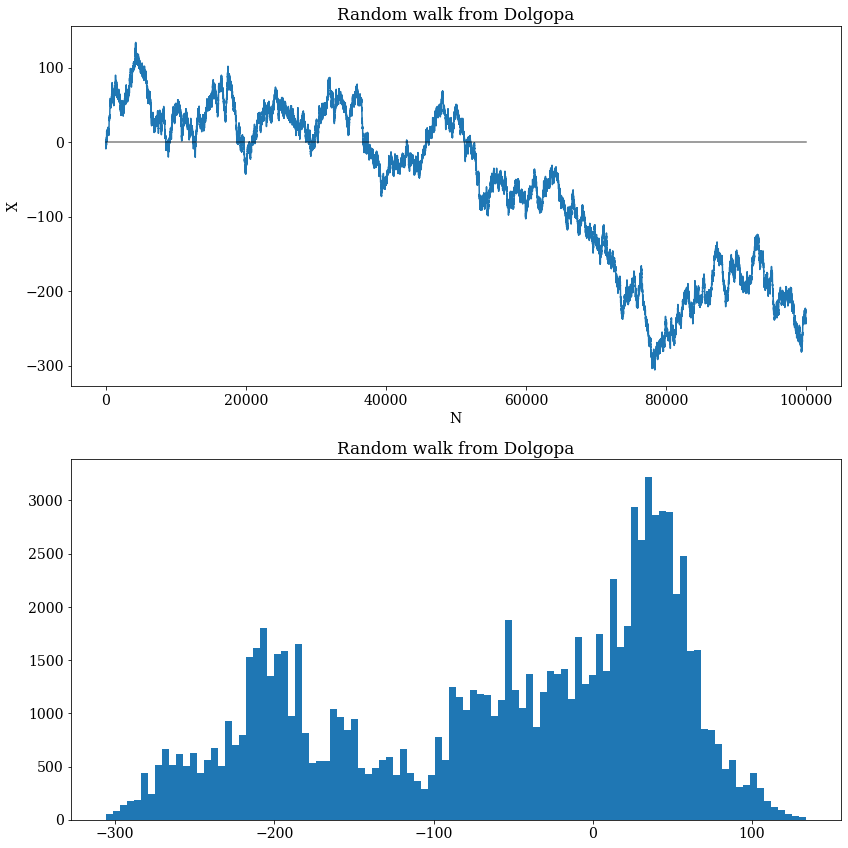

In [48]:
N = 100000
n = np.arange(0, N+1)
dx = np.random.choice([-1, 1], p=[0.5,0.5], size=N)
x = np.append(np.array([0]), np.cumsum(dx))


plt.figure(figsize=(12, 12))
plt.subplot(211)
plt.plot(n, x)
plt.plot([n[0],n[-1]], np.zeros(2), color="black", alpha=0.5)
plt.xlabel("N")
plt.ylabel("X")
plt.title("Random walk from Dolgopa")

plt.subplot(212)
# plt.plot(n, x)
# plt.xlabel("N")
# plt.ylabel("X")
plt.hist(x, bins=100)
plt.title("Random walk from Dolgopa")

plt.tight_layout()

Text(0.5, 0, 'X')

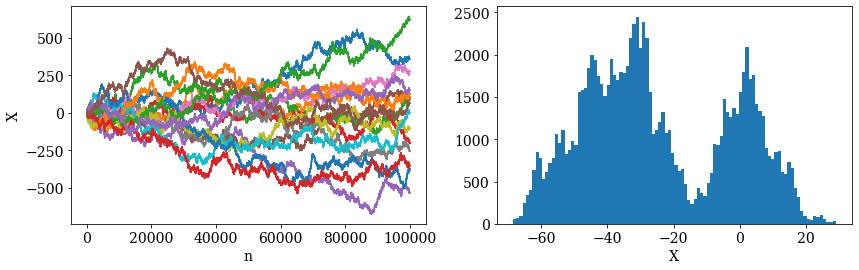

In [55]:
plt.figure(figsize=(14, 4))
plt.subplot(121)
           
res = []
for i in range(1, 17):
    dx = np.random.choice([-1, 1], p=[0.5,0.5], size=N)
    x = np.append(np.array([0]), np.cumsum(dx))
    res.append(x)
    plt.plot(n, x)
    plt.xlabel("n")
    plt.ylabel("X")


plt.subplot(122)
plt.hist(np.mean(res, axis=0),bins=100)
plt.xlabel("X")

# Семплирование.

Основная идея, на которой так или иначе основаны все алгоритмы сэмплирования, такова: если равномерно выбрать точку под графиком функции плотности распределения p, то её X-координата будет взята как раз по распределению p. Это очень легко понять интуитивно: представьте себе график плотности и разбейте его на маленькие столбики, примерно так 

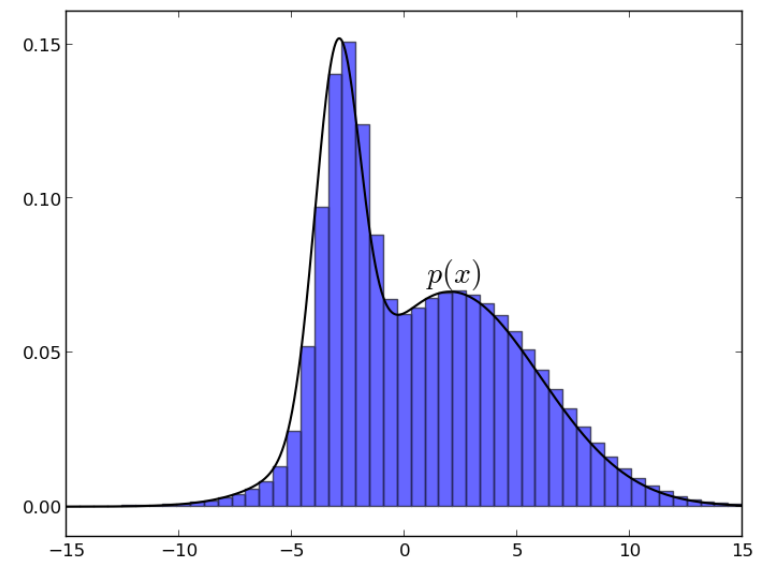 

Когда вы берёте случайную точку под графиком, каждая X-координата будет встречаться с вероятностью, пропорциональной высоте своего столбика, т.е. как раз со значением функции плотности на этом столбике.

Таким образом, нам нужно только научиться брать случайную точку под графиком плотности нужного распределения. Как же это сделать?

Будем строить случайное блуждание под графиком функции, переходя от одной точки к другой, и время от времени брать текущую точку блуждания в качестве сэмпла. Поскольку в данном случае это случайное блуждание является марковской цепью (т.е. его следующая точка зависит только от предыдущей, а памяти никакой нету), этот класс алгоритмов называется ещё MCMC-сэмплированием (Markov chain Monte Carlo). 

Итерация алгоритма Гастингса-Метрополиса для генерации выборок из распределения p.

- выбрать $x^{\prime}$ по распределению $q\left(x^{\prime} ; x^{(t)}\right)$;
- вычислить
$$
a=\frac{p\left(x^{\prime}\right)}{p\left(x^{(t)}\right)} \frac{q\left(x^{(t)} ; x^{\prime}\right)}{q\left(x^{\prime} ; x^{(t)}\right)}
$$
(не надо пугаться, $q\left(x^{(t)} ; x^{\prime}\right) / q\left(x^{\prime} ; x^{(t)}\right)$ для симметричных распределений, например гауссиана, равно 1, это просто поправка Гастингса на асимметрию);
- С вероятностью а (1, если а>1) $x^{(t+1)}:=x^{\prime}$, иначе $x^{(t+1)}:=x^{(t)}$.


Здесь q не должно быть приближением p, а должно просто быть каким-нибудь сэмплируемым распределением, которое сосредоточено в окрестности текущей точки — например, хорошо подходит сферический гауссиан с небольшой дисперсией.

Реализуем этот алгоритм на примере сэмплирования суммы двух гауссианов.

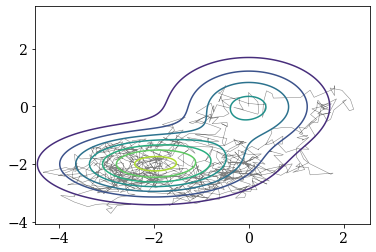

In [122]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.path as path
import matplotlib.mlab as mlab
import scipy
import scipy.stats as stats

delta = 0.025
X, Y = np.meshgrid(np.arange(-4.5, 2.0, delta), np.arange(-3.5, 3.5, delta))

z1 = stats.multivariate_normal([0,0],[[1.0,0],[0,1.0]])
z2 = stats.multivariate_normal([-2,-2],[[1.5,0],[0,0.5]])
def z(x): return 0.4*z1.pdf(x) + 0.6*z2.pdf(x)

Z01 = scipy.stats.multivariate_normal([0, 0], [[1.0, 0.0], [0.0, 1.0]])
Z1 = Z01.pdf(np.dstack((X, Y)))

Z02 = scipy.stats.multivariate_normal([-2, -2], [[1.5, 0], [0, 0.5]])
Z2 = Z02.pdf(np.dstack((X, Y)))


Z = 0.4*Z1 + 0.6*Z2

Q = stats.multivariate_normal([0,0],[[0.05,0],[0,0.05]])
r = [0,0]
samples = [r]
for i in range(0,1000):
	rq = Q.rvs() + r
	a = z(rq)/z(r)
	if np.random.binomial(1,min(a,1),1)[0] == 1:
		r = rq
		samples.append(r)

codes = np.ones(len(samples), int) * path.Path.LINETO
codes[0] = path.Path.MOVETO

p = path.Path(samples,codes)

fig, ax = plt.subplots()
ax.contour(X, Y, Z)
ax.add_patch(patches.PathPatch(p, facecolor='none', lw=0.5, edgecolor='gray'))
plt.show()


Итак, мы получили случайное блуждание под графиком плотности $p(\mathbf{x})$. Что теперь делать с этим случайным блужданием, нам же нужны независимые сэмплы, а тут получается, что следующая точка блуждания заведомо лежит рядом с предыдущей, и никакой независимости нет и в помине?


Ответ простой: нужно брать не каждую точку, а только некоторые, отделённые друг от друга многими шагами. Поскольку это случайное блуждание, то если большая часть q сосредоточена в радиусе $\varepsilon$, а общий радиус, в котором сосредоточено $p$, равен $D$, то для получения независимого сэмпла нужно будет порядка $\left(\frac{D}{\epsilon}\right)^2$ шагов. 

Это квадратичное число зависит от радиусов двух распределений, но при этом совершенно не зависит от размерности. Сэмплирование по методу марковских цепей Монте-Карло в гораздо меньшей степени подвержено проклятию размерности, чем другие методы; именно поэтому оно и стало, можно сказать, золотым стандартом. На практике, правда, $D$ оценить трудно, так что в конкретных реализациях обычно делают так: сначала некоторое достаточно число первых шагов, скажем 1000, отбрасывают (это называется burn-in, и это действительно важно, потому что начальная точка может попасть в неудачную область $p$, так что перед началом процесса надо точно убедиться, что мы уже ходили достаточно долго), а потом берут каждый $n$-й сэмпл, где $n$ подбирают экспериментально, исходя из реально получающейся автокорреляции в последовательности сэмплов.

## 4. Семплирование по Гиббсу.



Семплируйте по Гиббсу сумму двух гауссианов из разобранного примера.

***Теоретическая справка.***

Пусть есть совместное распределение $p\left(x_1, \ldots, x_d\right)$ для $d$ случайных величин, причём $d$ может быть очень большим. Пусть на шаге $t$ мы уже выбрали какое-то значение $X=\left\{x_i^t\right\}$. На каждом шаге делаются следующие действия:
1. Выбирается индекс $i:(1 \leq i \leq d)$.
2. $x_i^{t+1}$ выбирается по распределению $p\left(x_i \mid x_1^t, \ldots, x_{i-1}^t, x_{i+1}^t, \ldots, x_d^t\right)$, а для остальных индексов значение не меняется: $x_j^{t+1}=x_j^t(\mathrm{j} \neq \mathrm{i})$.


На практике обычно индекс выбирают не случайно, а последовательно. Алгоритм прост и не требует никаких специальных знаний и предположений, поэтому он популярен. Через несколько сотен/тысяч таких итераций случайные значения должны прийти к максимуму своей плотности. Дальнейшая тысяча итераций может уже использоваться по назначению как образец значений искомого распределения.

От общего случая блуждания по Метрополису-Гастингсу это отличается тем, что теперь мы двигаемся на каждом шаге вдоль одной из координатных осей; вот соответствующая картинка:  

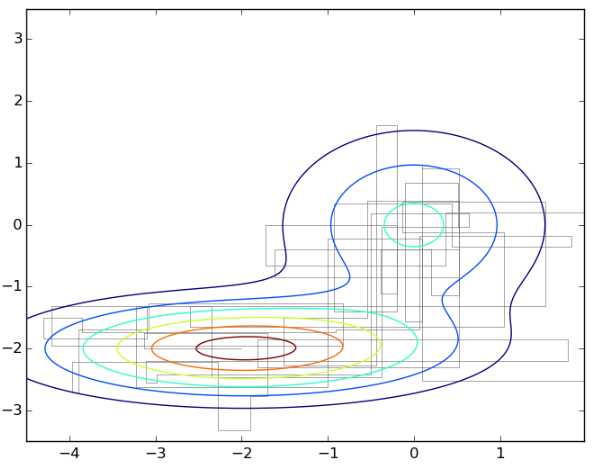



In [244]:
def distr(x, M1, S1, M2, S2, prop1, prop2):
    if prop1 + prop2 != 1:
        raise ValueError("prop1 + prop2 should equal to 1")
    return prop1 * sps.multivariate_normal(mean=M1, cov=S1).pdf(x) + prop2 * sps.multivariate_normal(mean=M2, cov=S2).pdf(x)


def gibbs_sampling(pdf, delta, size=100000, step=5, cut=1000):
    start = np.random.uniform(low=-0.5, high=0.5, size=2)
    
    points = [start]
    delta = delta.rvs(size=size)
    probs = sps.uniform.rvs(size=size)
    
    for i in range(size):
        cord = points[-1]
        new_cord = cord.copy()
        new_cord[i%2] += delta[i]
        p = pdf(new_cord)/pdf(cord)
        if p >= probs[i]:
            points.append(new_cord)
            
    return points[cut::step]

Text(0, 0.5, 'Y')

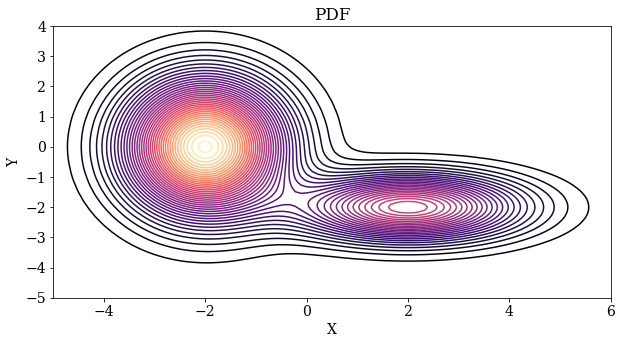

In [286]:
M1, M2 = np.array([-2.0, 0.0]), np.array([2.0, -2.0]), 
S1, S2 = np.diag([1.0, 2.0]), np.diag([2.0, 0.5])
prop1, prop2 = 0.7, 0.3

x, y = np.linspace(-5, 6, 100), np.linspace(-5, 4, 100)
xv, yv = np.meshgrid(x, y)

f = lambda x: distr(x, M1, S1, M2, S2, prop1, prop2)
delta = sps.norm(loc=0.0, scale=0.25)

plt.figure(figsize=(10, 5))
plt.contour(xv, yv, f(np.dstack([xv, yv])), levels=50, cmap='magma')
plt.title("PDF")
plt.xlabel("X")
plt.ylabel("Y")

In [267]:
points = gibbs_sampling(f, delta, size=10000, cut=500, step=1)

Text(0, 0.5, 'Y')

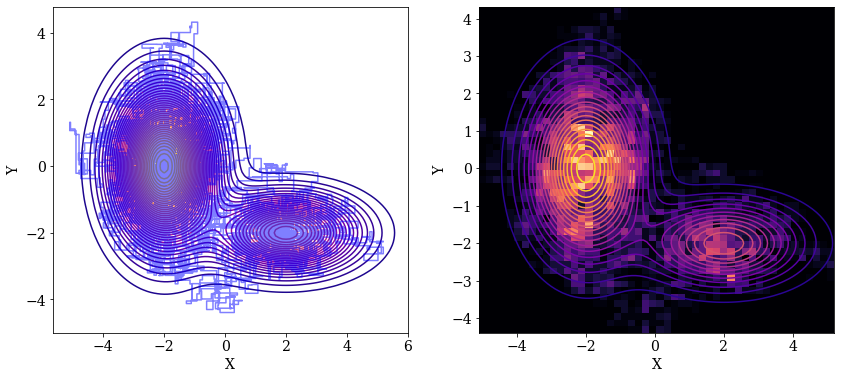

In [284]:
x, y = np.array(points).T

plt.figure(figsize=(14,6))
plt.subplot(121)
plt.contour(xv, yv, f(np.dstack([xv, yv])), levels=50, alpha=1.0, cmap="plasma")
plt.plot(x, y, color="blue", alpha=0.5)
plt.xlabel("X")
plt.ylabel("Y")

plt.subplot(122)
plt.hist2d(x, y, density=True, bins=50, cmap="magma")
plt.contour(xv, yv, f(np.dstack([xv, yv])), levels=20, alpha=1.0, cmap="plasma")
plt.xlabel("X")
plt.ylabel("Y")

## 5. Алгоритм Метрополиса-Хастингса - генерация выборок.

Сгенерируйте выборку из функции плотности $\pi(x) \sim \exp \left(-x^2\right)\left(3+\cos (x)+2 \sin (x)+x^2\right)$ применив алгоритм Метрополиса-Хастингса к случайному блужданию $x_{t+1}=x_t+\varepsilon_t$ где $\varepsilon_t \sim N(0,1)$.

***Теоретическая справка.***

Алгоритм Метрополиса - Гастингса  был впервые опубликован Николасом Метрополисом в 1953 году, и затем обобщён в 1970 году. Семплирование по Гиббсу является частным случаем алгоритма Метрополиса - Гастингса и более популярно за счёт простоты и скорости, хотя и реже применимо. Алгоритм Метрополиса - Гастингса позволяет семплировать любую функцию распределения. Он основан на создании цепи Маркова, то есть на каждом шаге алгоритма новое выбранное значение $x^{t+1}$ зависит только от предыдущего $x^t$. Алгоритм использует вспомогательную функцию распределения $Q\left(x^{\prime} \mid x^t\right)$, зависящую от $x^t$, для которой генерировать выборку просто (например, нормальное распределение). На каждом шаге для этой функции генерируется случайное значение $x^{\prime}$. Затем с вероятностью $u=\frac{P\left(x^{\prime}\right) Q\left(x^t \mid x^{\prime}\right)}{P\left(x^t\right) Q\left(x^{\prime} \mid x^t\right)} \quad$ (или $\quad$ с вероятностью 1 , если $u>1$ ), выбранное значение принимается как новое: $x^{t+1}=x^{\prime}$, а иначе оставляется старое: $x^{t+1}=x^t$. Например, если взять нормальную функцию распределения как вспомогательную функцию, то $Q\left(x^{\prime} \mid x^t\right) \sim N\left(x^t, \sigma^2 I\right)$. Такая функция выдаёт новое значение в зависимости от значения на предыдущем шаге. Изначально алгоритм Метрополиса требовал, чтобы вспомогательная функция была симметрична: $Q\left(x^{\prime}, x^t\right)=Q\left(x^t, x^{\prime}\right)$, однако обобщение Гастингса снимает это ограничение. 

Пусть мы уже выбрали случайное значение $x^t$. Для выбора следующего значения сначала получим случайное значение $x^{\prime}$ для функции $Q\left(x^{\prime} \mid x^t\right)$. Затем найдем произведение $a=a_1 a_2$, где 

$$
a_1=\frac{P\left(x^{\prime}\right)}{P\left(x^t\right)}
$$
является отношением вероятностей между промежуточным значением и предыдущим, а
$$
a_2=\frac{Q\left(x^t \mid x^{\prime}\right)}{Q\left(x^{\prime} \mid x^t\right)}
$$
это отношение между вероятностями пойти из $x^{\prime}$ в $x^t$ или обратно. Если $Q$ симметрична, то второй множитель равен 1. Случайное значение на новом шаге выбирается по правилу:  

$$
x^{t+1}=\left\{\begin{array}{cc}
x^{\prime} & \text { if } a>1 \\
x^{\prime} \text { with probability } a, & \text { if } a<1
\end{array}\right.  
$$

Это означает, что если $x^{\prime}$ более вероятно, чем текущее $x^t$, то мы всегда принимаем $x^{\prime}$ . Если он менее вероятен, чем текущий $x^t$, то мы можем принять его или отклонить случайным образом с уменьшением вероятности, чем меньше вероятность нового значения.

Алгоритм стартует из случайного значения $x^0$, и сначала прогоняется «вхолостую» некоторое количество шагов, чтобы «забыть»о начальном значении.

Лучше всего алгоритм работает тогда, когда форма вспомогательной функции близка к форме целевой функции $P$. Однако добиться этого априори зачастую невозможно. Для решения этой проблемы вспомогательную функцию настраивают в ходе подготовительной стадии работы алгоритма. Например, для нормального распределения настраивают его параметр $\sigma^2$ так, чтобы доля «принятых» случайных значений (то есть тех, для которых $x^{t+1}=x^{\prime}$ ) была близка к $60 \%$. Если $\sigma^2$ слишком мала, то значения будут получаться слишком близкими и доля принятых будет высока. Если $\sigma^2$ слишком велика, то с большой вероятностью новые значения будут выскакивать в зоны малой вероятности $P$, отчего доля принятых значений окажется низкой.  

In [317]:
def mh_sampler(pdf, delta, size=10000, step=5, cut=1000):
    start = np.random.uniform(low=-0.5, high=0.5, size=1)[0]
    
    points = [start]
    delta = delta.rvs(size=size)
    probs = sps.uniform.rvs(size=size)
    
    for i in range(size):
        cord = points[-1]
        new_cord = cord.copy()
        new_cord += delta[i]
        
        p = pdf(new_cord)/pdf(cord)
        if p >= probs[i]:
            points.append(new_cord)
            
    return np.array(points[cut::step])

In [318]:
pdf = lambda x: np.exp(-x**2) * (3 + np.cos(x) + 2*np.sin(x) + x**2)
delta = sps.norm(loc=0.0, scale=1.0)

size, step, cut = 100000, 1, 1000

In [319]:
points = mh_sampler(pdf, delta, size, step, cut)
points

array([-1.07744595, -1.79315647, -1.60257314, ...,  0.53782551,
        0.22521804,  0.66986733])

Text(0, 0.5, 'PDF')

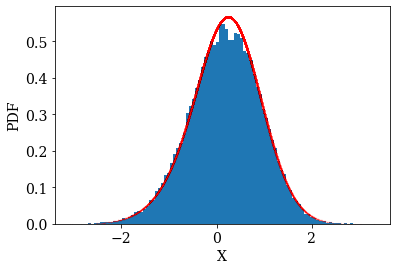

In [350]:
x = np.array(points).T

plt.hist(x, bins=100, density=True)
plt.scatter(x, pdf(x)/7.5, color="red", s=0.1, alpha=0.1)
plt.xlabel("X")
plt.ylabel("PDF")


Дополнительные материалы 

https://machinelearningmastery.ru/from-scratch-bayesian-inference-markov-chain-monte-carlo-and-metropolis-hastings-in-python-ef21a29e25a/  

https://rpubs.com/boris_demeshev/2909 

https://github.com/bdemeshev/mc201/wiki  

https://github.com/bdemeshev/mc201/wiki/Home2  